In [1]:
%env THEANO_FLAGS='device=cuda', 'floatX=float32', 'gpuarray.preallocate=0.5'

env: THEANO_FLAGS='device=cuda', 'floatX=float32', 'gpuarray.preallocate=0.5'


In [2]:
import numpy as np

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

## Data

In [4]:
%%time

try:
    f = np.load('HIGGS.npz')
    X = f['X']
    y = f['y']
    f.close()
except:
    n_samples = 11000000
    n_features = 28

    X = np.ndarray(shape=(n_samples, n_features), dtype='float32')
    y = np.ndarray(shape=(n_samples), dtype='uint16')

    with open('./HIGGS.csv', 'rb') as f:
        i = 0
        for line in tqdm_notebook(f, total=n_samples):
            sample = np.fromstring(line, dtype='float32', sep=',')
            X[i, :] = sample[1:]
            y[i] = int(sample[0])
            i += 1

    np.savez('HIGGS.npz', X = X, y = y)

CPU times: user 799 ms, sys: 360 ms, total: 1.16 s
Wall time: 1.17 s


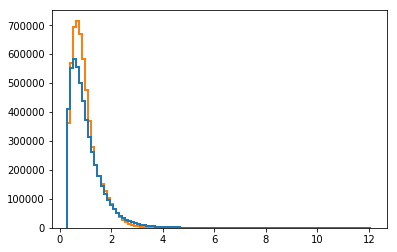

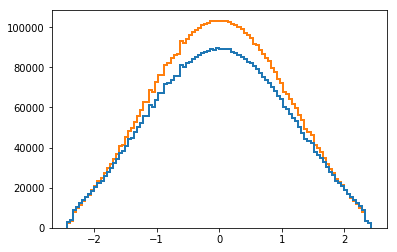

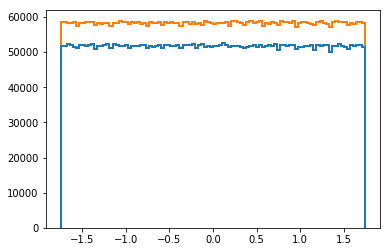

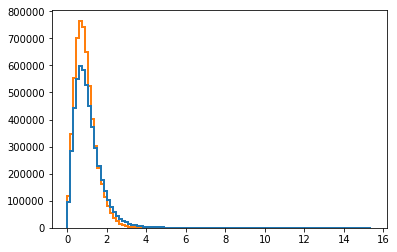

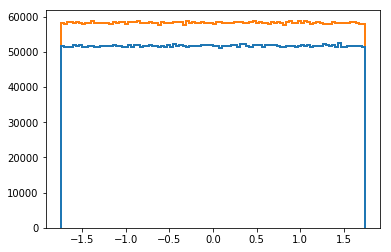

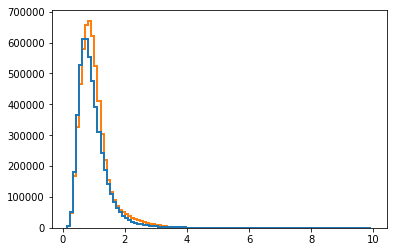

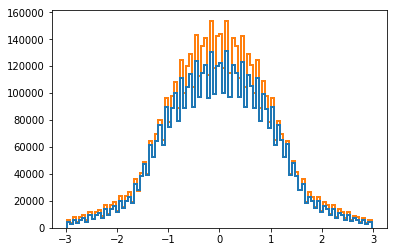

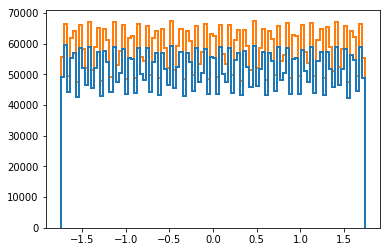

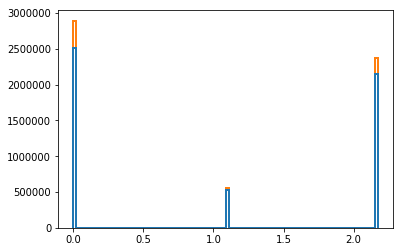

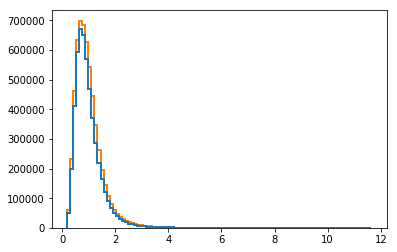

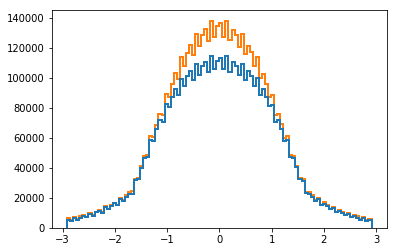

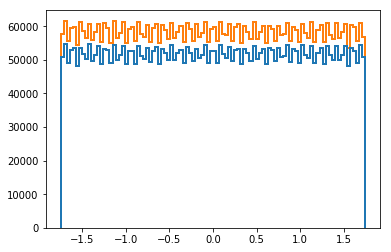

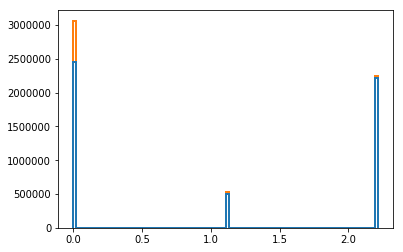

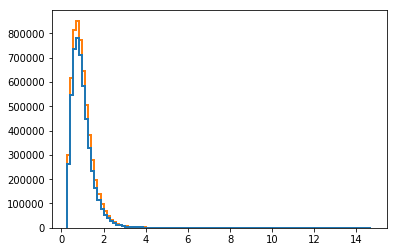

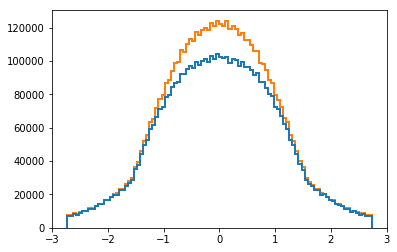

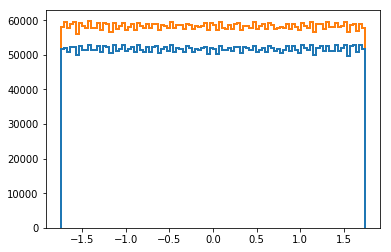

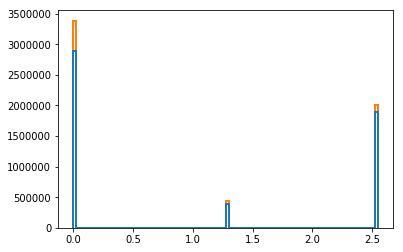

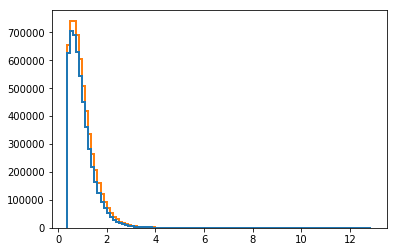

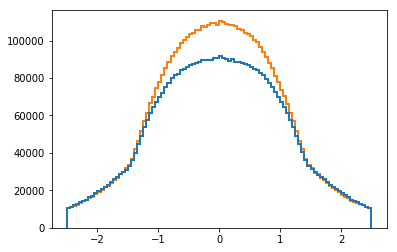

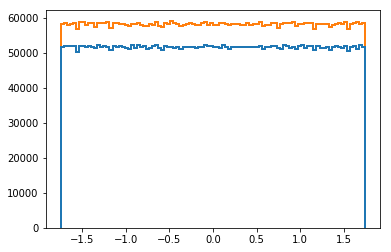

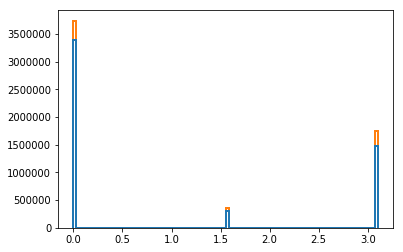

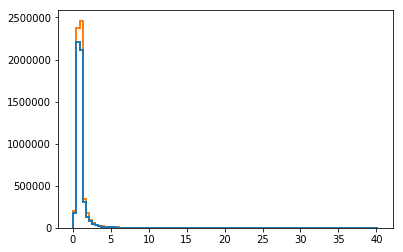

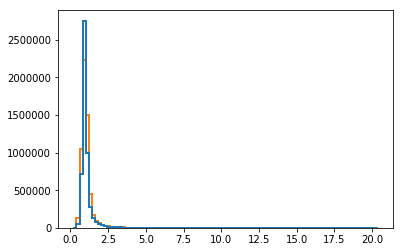

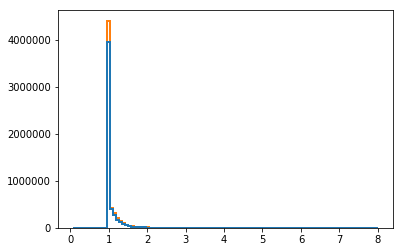

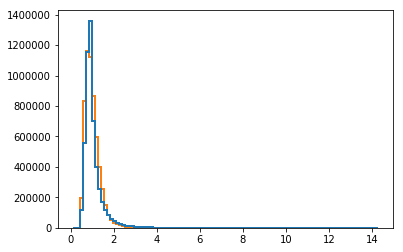

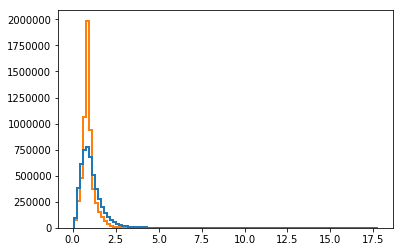

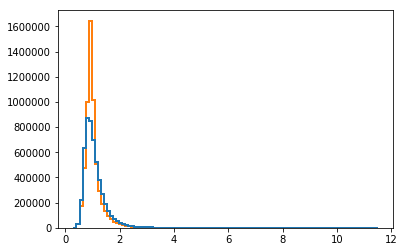

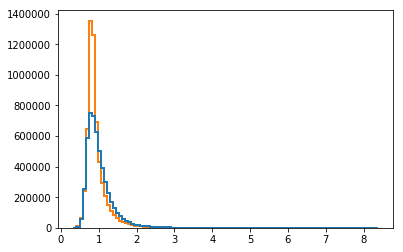

In [5]:
for i in range(X.shape[1]):
    plt.figure(figsize=(6, 4))
    _ = plt.hist(
        [ X[y == 0, i], X[y == 1, i] ],
        bins=100,
        histtype='step',
        lw=2
    )
    plt.show()

In [6]:
indx = np.random.permutation(X.shape[0])

n = indx.shape[0]

indx_train = indx[:n // 2]
indx_test = indx[n // 2:]

X_train = X[indx_train]
y_train = y[indx_train]

X_test = X[indx_test]
y_test = y[indx_test]

del X, y, indx_train, indx_test, indx

In [7]:
X_train_std = np.std(X_train, axis=0)
X_train /= X_train_std[None, :]

X_test /= X_train_std[None, :]

## Network

In [8]:
import theano
import theano.tensor as T

from craynn.layers import *
from craynn.subnetworks import *
from craynn.networks import *
from craynn.updates import *
from craynn.viz import draw_to_notebook, SNNWatcher

from lasagne.nonlinearities import LeakyRectify

from sklearn.metrics import roc_auc_score

Using cuDNN version 7005 on context None
Preallocating 4055/8110 Mb (0.500000) on cuda
Mapped name None to device cuda: GeForce GTX 1080 (0000:01:00.0)


In [9]:
nn = net((None, 28))(
    dense(512, f=T.nnet.softplus),
    dense(256, f=T.nnet.softplus),
    dense(128, f=T.nnet.softplus),
    dense(64, f=T.nnet.softplus),
    dense(32, f=T.nnet.softplus),
    dense(1, lambda x: x),
    flatten(outdim=1)
)

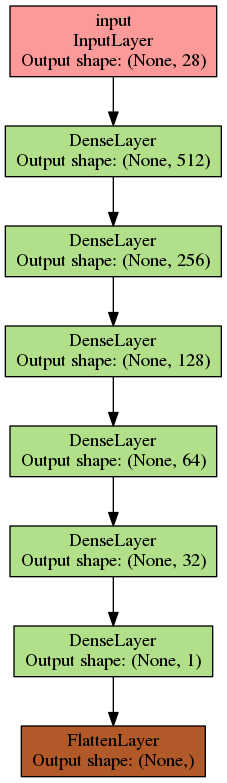

In [10]:
draw_to_notebook(nn)

In [11]:
X = T.fmatrix()
y = T.fvector()
w = T.fvector()

f, = nn(X)

losses = y * T.nnet.softplus(-f) + (1 - y) * T.nnet.softplus(f)

loss = T.mean(w * losses)

grads = theano.grad(T.mean(losses), nn.params())

grad_norm = sum(T.sum( g**2 ) for g in grads)

In [12]:
upd = adam(loss, nn.params(), learning_rate=1.0e-4)

In [13]:
train = theano.function([X, y, w], [loss, grad_norm], updates=upd, allow_input_downcast=True)

In [14]:
get_grad_norm = theano.function([X, y], grad_norm)

In [15]:
get_loss = theano.function([X, y], T.sum(losses))

In [16]:
predict = theano.function([X], T.nnet.sigmoid(f))

## Grouping

In [17]:
directions = T.fmatrix()

_project = theano.function([X, directions], X.dot(directions.T))

In [18]:
project = lambda x, d: np.vstack([
    _project(x[indx], d)
    for indx in streams.seq(x.shape[0], batch_size=16 * 1024)
])

In [19]:
from psgd.grouping import lsh_random_point_grid

In [20]:
X_train.shape[0]

5500000

In [21]:
X_train.shape[0] / 25 / 11 / 8 / 4

625.0

In [22]:
%%time

groups = np.array(lsh_random_point_grid(
    X_train, project, split_seq=(25, 11, 8, 5, 4)
))

CPU times: user 2.31 s, sys: 104 ms, total: 2.42 s
Wall time: 2.42 s


In [23]:
groups.shape

(44000, 125)

In [24]:
from psgd.sampling import SimpleSampler

In [25]:
sampler = SimpleSampler(n_objects=groups.shape[0])

In [26]:
grad_estimation = np.mean([
    get_grad_norm(X_train[groups[indx[0]]], y_train[groups[indx[0]]])
    for indx in streams.random(groups.shape[0], batch_size=1, n_batches=64)
])

## Training

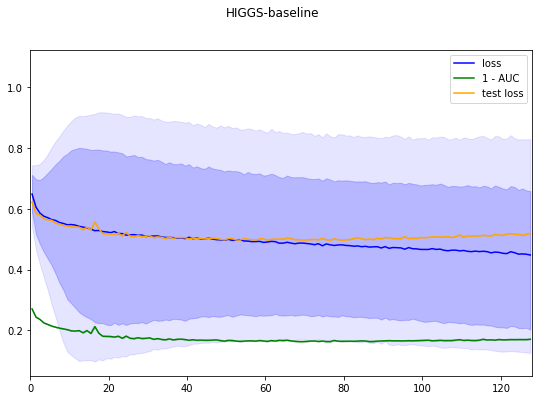

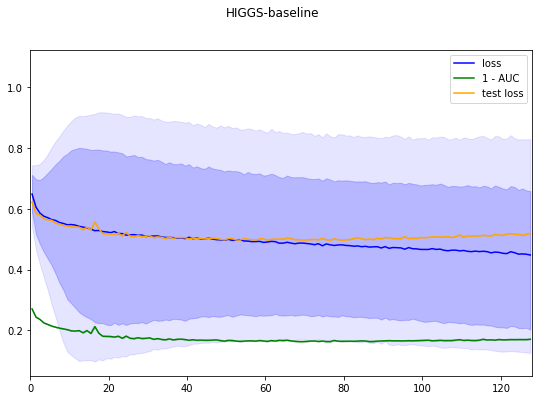

In [27]:
watcher = SNNWatcher(
    title='HIGGS-baseline', mode='fill',
    labels=['loss', '1 - AUC', 'test loss'],
    colors=['blue', 'green', 'orange']
)

n_epoches = 128
batch_size = 16
n_batches = X_train.shape[0] // batch_size // 16

loss_history = np.ndarray(shape=(n_epoches, n_batches), dtype='float32')
test_loss = np.ndarray(shape=(n_epoches, 1), dtype='float32')
auc_history = np.ndarray(shape=(n_epoches, 1), dtype='float32')

grad_acc = np.ones(shape=groups.shape[0], dtype='float32') * grad_estimation
rho = 0.95

priors = np.ones(shape=batch_size, dtype='float32') / groups.shape[0]

for i in range(n_epoches):
    sampler.set_probas(grad_acc)

    for j in range(n_batches):
        g_indx, probs = sampler.sample(1)
        sub_indx = np.random.permutation(groups[g_indx[0]][:batch_size])

        loss_history[i, j], g = train(X_train[sub_indx], y_train[sub_indx], priors / probs)
        
        grad_acc[g_indx] = rho * grad_acc[g_indx] + (1 - rho) * g
    
    test_loss[i, 0] = np.sum([
        get_loss(X_test[indx], y_test[indx])
        for indx in streams.seq(X_test.shape[0], batch_size=1024)
    ]) / X_test.shape[0]
    
    proba = np.hstack([
        predict(X_test[indx])
        for indx in streams.seq(X_test.shape[0], batch_size=1024)
    ])
    
    auc_history[i, 0] = roc_auc_score(y_test, proba)

    watcher.draw(
        loss_history[:(i + 1)],
        1 - auc_history[:(i + 1)],
        test_loss[:(i + 1)]
    )